### Import required libraries

In [1]:
from bs4 import BeautifulSoup
from Contractions import CONTRACTION_MAP
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, log_loss, precision_score
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, auc, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.linear_model import (LinearRegression, Ridge, Lasso)
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectPercentile, f_classif
from nltk.tokenize.toktok import ToktokTokenizer
tokenizer = ToktokTokenizer()

import unicodedata
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

#!pip install -U textblob
from textblob import TextBlob

#! python -m spacy download en
import spacy
nlp = spacy.load('en', parse = True, tag=True, entity=True)

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

### Convert generic_tweets.txt into a dataframe

In [3]:
generic_tweets_df = pd.read_table('generic_tweets.txt', delimiter=',')

In [4]:
generic_tweets_df.head()

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
generic_tweets_df.shape

(200000, 6)

### Export the df to a csv file

In [6]:
generic_tweets_df.to_csv('generic_tweets.csv')

### Make Canadian_Elections_2019 into a dataframe

In [268]:
canadian_elections_df= pd.read_csv('Canadian_elections_2019.csv')
canadian_elections_df.head()

,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h..."


In [8]:
canadian_elections_df.shape

(2133, 3)

### Now we have Canadian_elections_2019 and generic tweets datsets ready to analyse and understand. Lets perform Data Cleaning

## Step 1: Data Cleaning of generic_tweets and Canadian_elections_2019

### Creating a seperate df for clean generic_tweets and Candian_elections_2019

In [9]:
generic_tweets_df_clean=generic_tweets_df
canadian_elections_clean=canadian_elections_df

### 1.1 Remove the html tags(like html, h2)
    HTML tags are typically one of these components which don’t add much value towards understanding and analyzing text.

### Function to strip html tags

In [10]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

### Using the funtion to remove html tags in every row of generic_tweets

In [11]:
clean_text_0=[]
for row in generic_tweets_df.text:
    clean_text_0.append(strip_html_tags(row))

In [12]:
canada_text_0=[]
for row in canadian_elections_df.text:
    canada_text_0.append(strip_html_tags(row))

### 1.2 Remove Accented text
    we need to make sure that these characters are converted and standardized into ASCII characters. A simple example —  converting é to e.

### Function to remove accented characters

In [13]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

### Using the function to remove accented text in clean_text_0 which has html tags removed 

In [14]:
clean_text_1=[]
for item in clean_text_0:
    clean_text_1.append(remove_accented_chars(item))

In [15]:
canada_text_1=[]
for row in canada_text_0:
    canada_text_1.append(remove_accented_chars(row))

### (BONUS) 1.3 Expanding Contractions
    Contractions are shortened version of words or syllables. They often exist in either written or spoken forms in the English language. These shortened versions or contractions of words are created by removing specific letters and sounds. In case of English contractions, they are often created by removing one of the vowels from the word. Examples would be, do not to don’t and I would to I’d. Converting each contraction to its expanded, original form helps with text standardization.

### Function to expand contractions

In [16]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

### Using the function to expand contractions in clean_text_1 which has accented characters removed

In [17]:
clean_text_2=[]
for item in clean_text_1:
    clean_text_2.append(expand_contractions(item))

In [18]:
canada_text_2=[]
for row in canada_text_1:
    canada_text_2.append(expand_contractions(row))

### (BONUS) 1.4 Stemming
    To understand stemming, you need to gain some perspective on what word stems represent. Word stems are also known as the base form of a word, and we can create new words by attaching affixes to them in a process known as inflection. Consider the word JUMP. You can add affixes to it and form new words like JUMPS, JUMPED, and JUMPING. In this case, the base word JUMP is the word stem.

### Function to perform stemming

In [19]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

### Using the function to perform stemming on clean_text_2 which has contractions expanded

In [20]:
clean_text_3=[]
for item in clean_text_2:
    clean_text_3.append(simple_stemmer(item))

In [21]:
canada_text_3=[]
for row in canada_text_2:
    canada_text_3.append(simple_stemmer(row))

### (BONUS) 1.5 Lemmatization
    Lemmatization is very similar to stemming, where we remove word affixes to get to the base form of a word. However, the base form in this case is known as the root word, but not the root stem.

### Function to perform lemmatization

In [22]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

### Using the function to perform lemmatization on clean_text_3 which has stemming performed on it

In [23]:
clean_text_4=[]
for item in clean_text_3:
    clean_text_4.append(lemmatize_text(item))

In [24]:
canada_text_4=[]
for row in canada_text_3:
    canada_text_4.append(lemmatize_text(row))

### 1.6 Removing Stopwords
    Words which have little or no significance, especially when constructing meaningful features from text, are known as stopwords or stop words. These are usually words that end up having the maximum frequency if you do a simple term or word frequency in a corpus. Typically, these can be articles, conjunctions, prepositions and so on. Some examples of stopwords are a, an, the, and the like.

### We can make use of stop_words.txt file for this. Lets first convert this text file into a list

In [25]:
file = open('stop_words.txt', 'r')
stopword_list = [line.strip('\n') for line in file.readlines()]
len(stopword_list)

665

### Function to remove stopwords

In [26]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

### Using the function to removes stopwords on clean_text_4 which has lemmatization performed on it

In [27]:
clean_text_5=[]
for item in clean_text_4:
    clean_text_5.append(remove_stopwords(item))

In [28]:
canada_text_5=[]
for row in canada_text_4:
    canada_text_5.append(remove_stopwords(row))

### 1.7 Ensure all characters are in lower case

In [29]:
clean_text_6=[]
for item in clean_text_5:
    clean_text_6.append(item.lower())

In [30]:
canada_text_6=[]
for row in canada_text_5:
    canada_text_6.append(row.lower())

### 1.8 Remove HTTP Links/ urls

In [31]:
def remove_urls (vTEXT):
    vTEXT1 = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', vTEXT, flags=re.MULTILINE)
    return(vTEXT1)

In [32]:
clean_text_7=[]
for item in clean_text_6:
    clean_text_7.append(remove_urls(item))

In [33]:
canada_text_7=[]
for row in canada_text_6:
    canada_text_7.append(remove_urls(row))

### Now since we have cleaned the text column of generic_tweets and cnadian_elections, lets add this cleaned text as a new column into the respective dataframes

In [34]:
generic_tweets_df_clean['cleaned_text']=clean_text_7
canadian_elections_clean['cleaned_text']=canada_text_7


### Lets see how new dataframe looks like

In [35]:
generic_tweets_df_clean.head()

,class,id,date,query,user,text,cleaned_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","@switchfoot - awww , bummer . shoulda david c..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text ... cri result schoo...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,@kenichan dive mani time ball . manag save 50 ...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,bodi feel itchi fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....","@nationwideclass , behav . mad . whi ? becaus ."


In [36]:
canadian_elections_clean.head()

,sentiment,negative_reason,text,cleaned_text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",""" @rosiebarton suggestion , agre # canadian # ..."
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",""" #allwomanspacewalk real ! \n@space_st \n#eto..."
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",""" #brantford cost $ 94 billion 4 year ! justin..."
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...",""" #canada # canadaelection2019 # canadavot \n#..."
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",""" #canada # taxpay sick &amp; tire hard earn $..."


## 2. Exploratory Data Analysis

### 2.1 Lets determine a procedure to determine political affiliation. There are three political parties in consideration which are Liberal, Conservative and NDP. 

### 2.2 Let's try to associate each of the parties to its respective positive as well as negative identifiers 
####    Procedure Followed:

#### 1. For positive identifiers :
    Did background study on each party and jotted down their taglines, promotion topics, campaign slogans, promises for the future, names of major people involved etc. 

#### 2. For negative identifiers :
    Did background study on scams in which a party is accused of, cases against parties, policies that did not go well, talks that werent well recieved etc.

#### 3. Club party wise:
    The postive and negative identifiers are clubbed for each party and they are used to identify the political affiliation by analyzing if the tweet contains any of these identifiers while the sentiment/class column tells us about the type of sentiment which could be either positive or negative.

    1.Liberal Party - "Justin Trudeau" ;
                      "Trudeau";
                      "Justin"
                      "Choose forward";
                      "Proven leadership for a strong Canada";
                      "Safer Canada/Stronger Economy";
                      "Protect our Economy";
                      "liberal";
                      "#LavScam";
                      "Trudeau must go";
                      "#TrudeauMustGo";
                      "#LiberalsMustGo"
                      "#TrudeauBlackface";
                      "#NotAsAdvertised";
                      "#LiberalLiesAndDeception";

    2.Conservative Party of Canada -"Andrew Scheer"; 
                                    "Andrew";
                                    "Scheer";
                                    "#Scheer4PM";
                                    "#ScheerMajority";
                                    "It's time for you to get ahead";
                                    "conservative";
                                    "Real Change (Now)";
                                    "#ScheerLies";
                                    "#ScheerStupidity";
                                    "#ScheerDelusion";
                                    "#Scheer2019"
    3.NDP - "Jagmeet Singh" ; 
            "Jagmeet";
            "Singh";
            "In it for you" ; 
            "We fight for you" ;
            "Ready for Change";
            "#SinghUpSwing";
            "#Jaggernaut";
            "#UpRiSingh"

### 2.3 Lets convert the above into a dictionary which can map identifiers with each poltical party

In [458]:
political_party_mapper = {
    'Liberal Party' :
                ['Justin Trudeau' ,
                  'Trudeau',
                  'Justin',
                  'Chooseforward',
                  'Proven leadership for a strong Canada',
                  'Safer Canada/ Stronger Economy',
                  'Protect our Economy',
                  'liberal',
                  'teamtrudeau',
                  'lpc',
                  'red',
                  'LavScam',
                  'Trudeaumustgo',
                  'TrudeauMustGo',
                  'LiberalsMustGo',
                  'TrudeauBlackface',
                  'NotAsAdvertised',
                  'LiberalLiesAndDeception'],
    
    'Conservative Party' : 
                    ['Andrew Scheer', 
                    'Andrew',
                    'Scheer',
                    'Scheer4PM',
                    'ScheerMajority',
                    'It is time for you to get ahead',
                    'conservative',
                    'blue',
                    'Real Change (Now)',
                    'ScheerLies',
                    'ScheerStupidity',
                    'ScheerDelusion',
                    'Scheer2019'],
    'NDP' :
                    ['Jagmeet Singh' , 
                    'Jagmeet',
                    'Singh',
                    'orange',
                    'In it for you' , 
                    'We fight for you' ,
                    'Ready for Change',
                    'SinghUpSwing',
                    'Jaggernaut',
                    'UpRiSingh']
}

### 2.4 Let's use this mapper to find out political affiliation in each of the tweets in Canadian_Elections_2019. And let's introduce a new column called 'Political Party' to that dataframe which will contain the poltical parties referenced by each tweet

In [459]:
canadian_elections_clean['Poltical_Party']='None'

In [462]:
for row in range(len(canada_text_7)):
    for text in canada_text_7:
        for party in political_party_mapper.keys():
            for identifier in political_party_mapper[party]:
                if identifier.lower() in canada_text_7[row]:
                    canadian_elections_clean['Poltical_Party'].iloc[row]=party

In [40]:
#old
canadian_elections_clean.Poltical_Party.value_counts(dropna=False)

None                  1150
Conservative Party     464
Liberal Party          376
NDP                    143
Name: Poltical_Party, dtype: int64

### 2.5 Let's use this mapper to find out political affiliation in each of the tweets in generic_tweets.Note that the amount of data in this dataframe is extremey huge. So lets devise a different technique , unlike the previous method to find political inclinations. 

### 2.5.1 Lets first find how many of the tweets are affiliated towards Liberal Party

In [41]:
generic_tweets_df_clean["Poltical_Party"] = generic_tweets_df_clean['cleaned_text'].\
str.contains('justintrudeau|trudeau|justin|chooseforward|safercanada|strongereconomy|protectoureconomy|\
liberal|lavscam|trudeaumustgo|trudeauMustGo|liberalsmustgo|trudeaublackface|notasadvertised|liberalliesanddeception')
generic_tweets_df_clean.loc[generic_tweets_df_clean["Poltical_Party"] == True, "Liberal_Party"] = 'Liberal Party'
generic_tweets_df_clean.loc[generic_tweets_df_clean["Poltical_Party"] == False, "Liberal_Party"] = None

In [42]:
generic_tweets_df_clean.Liberal_Party.value_counts(dropna=False)

NaN              199770
Liberal Party       230
Name: Liberal_Party, dtype: int64

### 2.5.2 Lets first find how many of the tweets are affiliated towards Conservative Party

In [43]:
generic_tweets_df_clean["Poltical_Party"] = generic_tweets_df_clean['cleaned_text'].\
str.contains('andrew scheer|andrew|scheer|scheer4PM|scheerMajority|it is time for you to get ahead|conservative|\
real change (Now)|scheerlies|scheerstupidity|scheerdelusion|scheer2019')
generic_tweets_df_clean.loc[generic_tweets_df_clean["Poltical_Party"] == True, "Conservative_Party"] = 'Conservative Party'
generic_tweets_df_clean.loc[generic_tweets_df_clean["Poltical_Party"] == False, "Conservative_Party"] = None

C:\Users\nileena\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until


In [44]:
generic_tweets_df_clean.Conservative_Party.value_counts(dropna=False)

NaN                   199809
Conservative Party       191
Name: Conservative_Party, dtype: int64

### 2.5.3 Lets first find how many of the tweets are affiliated towards NDP

In [45]:
generic_tweets_df_clean["Poltical_Party"] = generic_tweets_df_clean['cleaned_text'].\
str.contains('jagmeet singh|jagmeet|singh|in it for you |we fight for you|ready for change|singhupswing|jaggernaut|uprisingh')
generic_tweets_df_clean.loc[generic_tweets_df_clean["Poltical_Party"] == True, "NDP"] = 'NDP'
generic_tweets_df_clean.loc[generic_tweets_df_clean["Poltical_Party"] == False, "NDP"] = None

In [46]:
generic_tweets_df_clean.NDP.value_counts(dropna=False)

NaN    199985
NDP        15
Name: NDP, dtype: int64

### 2.6 Lets now try to visualise interesting aspects of Canadian_Elections

### 2.6.1 Let's see which party has been popularly discussed referring to Canadian_elections dataset

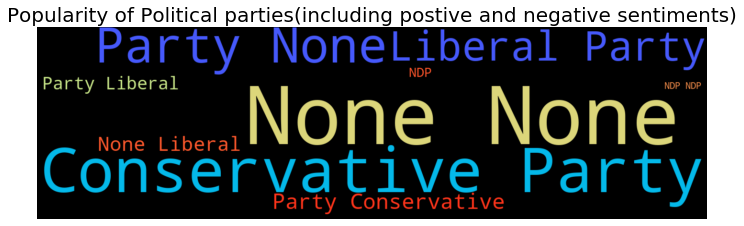

In [47]:
column_start = canadian_elections_clean.Poltical_Party
wc = (WordCloud(height=400,width=1400, max_words=1000, stopwords=STOPWORDS,
                colormap='rainbow',background_color='black'
              ).generate(' '.join(column_start.dropna().astype(str))))

plt.figure(figsize=(12,8))
plt.title("Popularity of Political parties(including postive and negative sentiments)", fontsize=20)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Inference    
    1. From the above wordcloud, we can infer that most of the parties referred to Canadian elections dataset is None or 
    Other which means -not Liberal,Conservative or NDP.
    2. Well, the interesting fact is that conservative party is most dicussed after None followed by Liberal and NDP
    3. But, this need not mean conservative party is the most popular amongst people as we havent taken in consideration 
    of sentiment factor. Lets try to analyse from the sentiment angle in the following

### 2.6.2 Let's see which party has been discussed more with positive sentiment referring to Canadian_elections_2019 dataset

In [48]:
canadian_elections_clean_positive=canadian_elections_clean[canadian_elections_clean.sentiment=='positive']


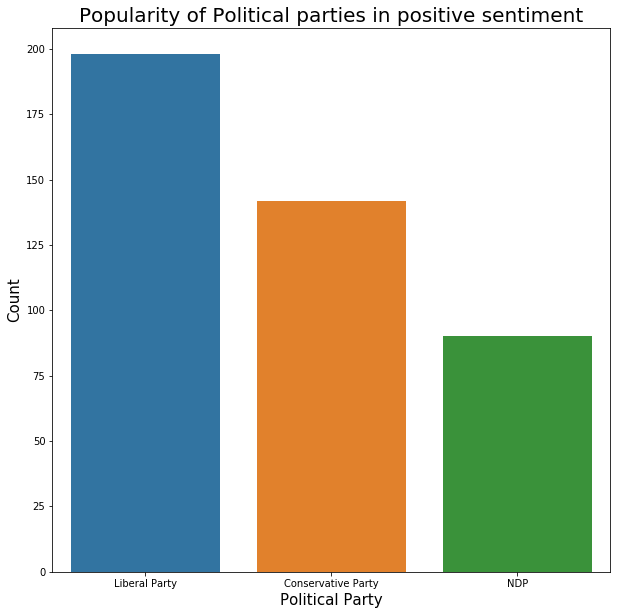

In [49]:
order = ['Liberal Party','Conservative Party','NDP']
plt.figure(figsize=(10,10))
sns.countplot(canadian_elections_clean_positive['Poltical_Party'], order=order)
plt.xlabel("Political Party", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Popularity of Political parties in positive sentiment", fontsize=20)
plt.show()

#### Inference:
    The interesting difference from the above wordcloud is very evident here. Conservative is no longer the popular one
    (like in wordcloud) but it is the liberal which is discussed most with positive sentiment followed by conservative 
    and NDP

### (BONUS) 2.6.3 Let's see which party has been discussed more with negative sentiment referring to Canadian_elections_2019 dataset

In [50]:
canadian_elections_clean_negative=canadian_elections_clean[canadian_elections_clean.sentiment=='negative']

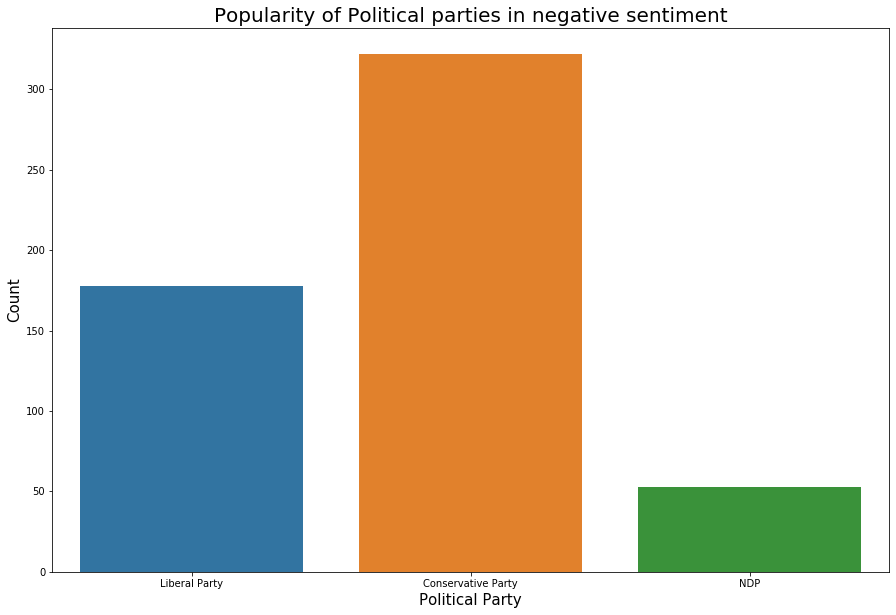

In [51]:
order = ['Liberal Party','Conservative Party','NDP']
plt.figure(figsize=(15,10))
sns.countplot(canadian_elections_clean_negative['Poltical_Party'], order=order)
plt.xlabel("Political Party", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.title("Popularity of Political parties in negative sentiment", fontsize=20)
plt.show()

#### Inference
    Conservative party is the most discussed in negative sentiment followed by Liberalparty and NDP. This could be because 
    of scams, difference in philosophies/perspectives, ideological differences etc.

#### (BONUS) 2.6.4 Another way of visualising which party is more popular amngst the three?

In [429]:
import plotly.offline as py
import plotly.graph_objs as go

#colors1 = ['dodgerblue', 'plum', '#F0A30A','#8c564b']
colors1 = ['red','green','blue']
counts = canadian_elections_clean[canadian_elections_clean['Poltical_Party']!='None']['Poltical_Party'].value_counts(sort=True)
labels = counts.index
values = counts.values
pie = go.Pie(labels=labels, values=values, marker=dict(colors=colors1,line=dict(color='#000000', width=1)))
layout = go.Layout(title='Popularity amongst 3 poltical parties amongst public tweets')
fig = go.Figure(data=[pie], layout=layout)
py.iplot(fig)


### 2.7 Let's anlayse if there are any striking patterns with generic_tweets as well

### (BONUS) 2.7.1 Let's analyse which are the most commonly tweeted topics/words

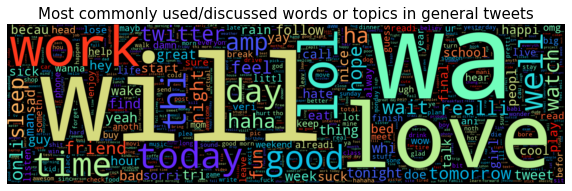

In [52]:
column_start = generic_tweets_df_clean.cleaned_text
wc = (WordCloud(height=400,width=1400, max_words=1000, stopwords=STOPWORDS,
                colormap='rainbow',background_color='black'
              ).generate(' '.join(column_start.dropna().astype(str))))

plt.figure(figsize=(10,10))
plt.title("Most commonly used/discussed words or topics in general tweets", fontsize=15)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Inference:
    Well this wordcloud is all about -"What do people generally or commonly tweet about. Some of the top picked words can 
    be :
    
    1. Work - Could be things at work, work life, recent trends in their respective work domains
    2. Love - Could be about humanity, spreading love, LGBTQ
    3. Good - Could be in appreciation of some action by government or individuals or organizations, encouraging to be kind 
       and good 
    4. Lol - Could be trolls, memes on hot burning topics or individuals
    5. Time - Could be about the changing times, good/bad times, current/past/future events

### (BONUS) 2.7.2 Lets analyse distribution of positive/negative sentiments for each party from generic_tweets 

In [372]:
import plotly.offline as py
import plotly.graph_objs as go

generic_tweets_df_clean_liberal=generic_tweets_df_clean[generic_tweets_df_clean.Liberal_Party=='Liberal Party']
generic_tweets_df_clean_conservative=generic_tweets_df_clean[generic_tweets_df_clean.Conservative_Party=='Conservative Party']
generic_tweets_df_clean_ndp=generic_tweets_df_clean[generic_tweets_df_clean.NDP=='NDP']
#colors1 = ['dodgerblue', 'plum', '#F0A30A','#8c564b']
colors1 = ['green', 'red']
counts1 = generic_tweets_df_clean_liberal['class'].value_counts(sort=True)
counts2 = generic_tweets_df_clean_conservative['class'].value_counts(sort=True)
counts3 = generic_tweets_df_clean_ndp['class'].value_counts(sort=True)
labels1 = counts1.index
map={0:'Negative','4':'Positive',4:'Positive'}
labels2 = labels1.map(map)
values1 = counts1.values
values2 = counts2.values
values3 = counts3.values

pie1 = go.Pie(labels=labels2, values=values1, marker=dict(colors=colors1,line=dict(color='#000000', width=1)))
pie2 = go.Pie(labels=labels2, values=values2, marker=dict(colors=colors1,line=dict(color='#000000', width=1)))
pie3 = go.Pie(labels=labels2, values=values3, marker=dict(colors=colors1,line=dict(color='#000000', width=1)))

layout1 = go.Layout(title='Liberal Party')
layout2 = go.Layout(title='Conservative Party')
layout3 = go.Layout(title='NDP')

fig1 = go.Figure(data=[pie1], layout=layout1)
fig2 = go.Figure(data=[pie2], layout=layout2)
fig3 = go.Figure(data=[pie3], layout=layout3)

py.iplot(fig1)
py.iplot(fig2)
py.iplot(fig3)

#### Inference
    Another interesting thing to look at would be the sentiment distribution within tweets for each of the three 
    political parties - Liberal,Conservative and NDP.
    
    Though Liberal is the most positively discussed political party when compared to the other two, analyzing the 
    tweets individually for political parties brought out an interesting perspective - Positive sentiments for 
    Conservative party (60.7%) were slightly higher than liberal(59.6%) while the negative sentiment is highest for 
    NDP (46.7%). Note that the total number of tweets are very different for each party but it is insightful to look 
    at this distribution of sentiment within tweets for each party

### 3. Model Preparation

#### What is asked for? 

    Split the generic tweets randomly into training data (70%) and test data (30%). Prepare the data to try multiple classification algorithms (logistic regression, k-NN, Naive Bayes, SVM, decision trees, ensembles (RF, XGBoost)) , where each tweet is considered a single observation/example. In these models, the target variable is the sentiment value, which is either positive or negative. Try two different types of features, Bag of words (word frequency) and TF-IDF.

### 3.1 Bag of Words

    Bag of Words (BOW) is a method to extract features from text documents. These features can be used for training machine learning algorithms. It creates a vocabulary of all the unique words occurring in all the documents in the training set.In simple terms, it’s a collection of words to represent a sentence with word count and mostly disregarding the order in which they appear.

    On a high level, it involves the following steps:
        1.Clean data
        2.Tokenize
        3.Build vocab
        4.Generate vectors

### Function to create bag of words

In [54]:
def create_bag_of_words(filename, k):
    '''
    The function takes a list as input and count the word frequency of top k word in the list.
    Additionally, it also counts the word frequency in each element in the list.
    The return result is a dataframe with word frequency and sentiment(target).
    '''
    counter = Counter()
   
    for i in range(len(filename)):
        counter.update([word for word in re.findall(r'\w+', filename[i])]) #if word not in noise_word       
    topk = counter.most_common(k)
   
    np_array= []
   
    for i in range(len(filename)):
            tempCounter = Counter([word for word in re.findall(r'\w+', filename[i])])
            topkintweet = [tempCounter[word] if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
            np_array.append(topkintweet)
               
    feature_df = pd.DataFrame(np_array)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    feature_df.columns = dfName
   
    print("Process is done!")
   
    return feature_df

In [55]:
bag_of_words_df = create_bag_of_words(generic_tweets_df_clean['cleaned_text'],500)

Process is done!


In [98]:
bag_of_words_df.shape

(200000, 500)

### 3.2 TF-IDF

    TF-IDF stands for “Term Frequency — Inverse Document Frequency”. This is a technique to quantify a word in documents, we generally compute a weight to each word which signifies the importance of the word in the document and corpus. This method is a widely used technique in Information Retrieval and Text Mining.
  
##### Term Frequency(TF):
        This measures the frequency of a word in a document. This highly depends on the length of the document and the generality of word
        
##### Document Frequency:
        This measures the importance of document in whole set of corpus, this is very similar to TF. The only difference is that TF is frequency counter for a term t in document d, where as DF is the count of occurrences of term t in the document set N. In other words, DF is the number of documents in which the word is present.
        
##### Inverse Document Frequency(IDF):
    IDF is the inverse of the document frequency which measures the informativeness of term t. When we calculate IDF, it will be very low for the most occurring words such as stop words (because stop words such as “is” is present in almost all of the documents, and N/df will give a very low value to that word). This finally gives what we want, a relative weightage.

In [369]:
#The input parameter is the text of the cleaned generic tweets and the ouput is the sentiment value 0 or 4
#Data set is split into 70-30 train-test split

X = generic_tweets_df_clean['cleaned_text']
y = generic_tweets_df_clean['class']

TV = TfidfVectorizer(max_features=30000,ngram_range=(1, 10), smooth_idf=True, sublinear_tf=False, use_idf=True)

#Conversion of tweets in train and test data to TF-ID form
X_TFIDF = TV.fit_transform(X)
X_trainTV, X_testTV, y_train, y_test = train_test_split(X_TFIDF,y,test_size=0.3)

#Conversion of the output test and train values to integers
y_train = y_train.astype('int')
y_test = y_test.astype('int')

### 3.3 Logistic Regression

    Logistic regression is the appropriate regression analysis to conduct when the dependent variable is dichotomous 
    (binary).  Like all regression analyses, the logistic regression is a predictive analysis.  Logistic regression is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables

### 3.3.1 Implementing Logisitc Regression with Bag of Words Feature

In [134]:
X= bag_of_words_df
y=generic_tweets_df_clean['class']

model_lr = linear_model.LogisticRegression(multi_class='ovr')
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 9)
sc_x = StandardScaler() 
xtrain = sc_x.fit_transform(X_train)  
xtest = sc_x.transform(X_test)
model_lr.fit(X_train, y_train)
    
predictions = model_lr.predict(X_test)

y_test_pred = model_lr.predict(X_test)
y_train_pred = model_lr.predict(X_train)
predtest = model_lr.predict_proba(X_test)
predtrain = model_lr.predict_proba(X_train)

#finding the accuracy, precision and test_error
accuracy_test = accuracy_score(y_test, y_test_pred)
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_test = precision_score(y_test , y_test_pred, average ='macro')
precision_train = precision_score(y_train , y_train_pred, average ='macro')

print("Accuracy_test: {}%".format(round(np.mean(accuracy_test)*100,3)))
print("Accuracy_train: {}%".format(round(np.mean(accuracy_train)*100,3))) 
print("precision_test: {}%".format(round(np.mean(precision_test)*100,3)))
print("precision_train: {}%".format(round(np.mean(precision_train)*100,3)))    

Accuracy_test: 69.74%
Accuracy_train: 70.296%
precision_test: 70.113%
precision_train: 70.664%


### 3.3.2 Implementing Logistic Regression with TF-IDF feature

In [90]:
model_lr.fit(X_trainTV, y_train)
    
predictions = model_lr.predict(X_testTV)
# classifier = LogisticRegression(random_state = 0)

y_test_pred = model_lr.predict(X_testTV)
y_train_pred = model_lr.predict(X_trainTV)
predtest = model_lr.predict_proba(X_testTV)
predtrain = model_lr.predict_proba(X_trainTV)

#finding the accuracy, precision and test_error
accuracy_test = accuracy_score(y_test, y_test_pred)
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_test = precision_score(y_test , y_test_pred, average ='macro')
precision_train = precision_score(y_train , y_train_pred, average ='macro')

print("Accuracy_test: {}%".format(round(np.mean(accuracy_test)*100,3)))
print("Accuracy_train: {}%".format(round(np.mean(accuracy_train)*100,3))) 
print("precision_test: {}%".format(round(np.mean(precision_test)*100,3)))
print("precision_train: {}%".format(round(np.mean(precision_train)*100,3)))   

Accuracy_test: 74.077%
Accuracy_train: 79.269%
precision_test: 74.155%
precision_train: 79.361%


### 3.4 K-NN Classification Algorithm 

    The kNN algorithms classifies by comparing to nearest neighbours and sets the classification the same as the majority of the neighbours. The advantage of kNN is that it is easy to interpret and has low calculation time. The disadvantage is that it is sensitive to irrelevant attributes and to class-outliers.

### 3.4.1 Implementing kNN with Bag of Words
##### Note: Below code is commented because it takes a lot of time to run

In [465]:
# X= bag_of_words_df
# y=generic_tweets_df_clean['class']

# model_knn = KNeighborsClassifier()
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 9)
# sc_x = StandardScaler() 
# xtrain = sc_x.fit_transform(X_train)  
# xtest = sc_x.transform(X_test)
# model_knn.fit(X_train, y_train)
    
# predictions = model_knn.predict(X_test)

# y_test_pred = model_knn.predict(X_test)
# y_train_pred = model_knn.predict(X_train)
# predtest = model_knn.predict_proba(X_test)
# predtrain = model_knn.predict_proba(X_train)

# #finding the accuracy, precision and test_error
# accuracy_test = accuracy_score(y_test, y_test_pred)
# accuracy_train = accuracy_score(y_train, y_train_pred)
# precision_test = precision_score(y_test , y_test_pred, average ='macro')
# precision_train = precision_score(y_train , y_train_pred, average ='macro')

# print("Accuracy_test: {}%".format(round(np.mean(accuracy_test)*100,3)))
# print("Accuracy_train: {}%".format(round(np.mean(accuracy_train)*100,3))) 
# print("precision_test: {}%".format(round(np.mean(precision_test)*100,3)))
# print("precision_train: {}%".format(round(np.mean(precision_train)*100,3)))  
 

Accuracy_test: 62.52 %
Accuracy_train: 63.7 %
precision_test: 61.226 %
precision_train: 63.425 %


### 3.4.2 Implementing kNN with TF-IDF
##### Note: Below code is commented because it takes a lot of time to run

In [466]:
# model_Knn.fit(X_trainTV, y_train)
    
# predictions = model_knn.predict(X_testTV)
# # classifier = LogisticRegression(random_state = 0)

# y_test_pred = model_knn.predict(X_testTV)
# y_train_pred = model_knn.predict(X_trainTV)
# predtest = model_knn.predict_proba(X_testTV)
# predtrain = model_knn.predict_proba(X_trainTV)

 

# #finding the accuracy, precision and test_error
# accuracy_test = accuracy_score(y_test, y_test_pred)
# accuracy_train = accuracy_score(y_train, y_train_pred)
# precision_test = precision_score(y_test , y_test_pred, average ='macro')
# precision_train = precision_score(y_train , y_train_pred, average ='macro')

# print("Accuracy_test: {}%".format(round(np.mean(accuracy_test)*100,3)))
# print("Accuracy_train: {}%".format(round(np.mean(accuracy_train)*100,3))) 
# print("precision_test: {}%".format(round(np.mean(precision_test)*100,3)))
# print("precision_train: {}%".format(round(np.mean(precision_train)*100,3)))   


Accuracy_test: 63.7 %
Accuracy_train: 64.90 %
precision_test: 62.6 %
precision_train: 64.121 %


### 3.5 Naive Bayes

    A Naive Bayes classifier is a probabilistic machine learning model that’s used for classification task. The crux of the classifier is based on the Bayes theorem.Using Bayes theorem, we can find the probability of A happening, given that B has occurred. Here, B is the evidence and A is the hypothesis. The assumption made here is that the predictors/features are independent. That is presence of one particular feature does not affect the other. Hence it is called naive.

### 3.5.1 Implementing Naive Bayes with Bag of Words

In [73]:
X= bag_of_words_df
y=generic_tweets_df_clean['class']

model=GaussianNB()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 9)
sc_x = StandardScaler() 
xtrain = sc_x.fit_transform(X_train)  
xtest = sc_x.transform(X_test)
model.fit(X_train, y_train)
    
predictions = model.predict(X_test)

y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
predtest = model.predict_proba(X_test)
predtrain = model.predict_proba(X_train)

#finding the accuracy, precision and test_error
accuracy_test = accuracy_score(y_test, y_test_pred)
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_test = precision_score(y_test , y_test_pred, average ='macro')
precision_train = precision_score(y_train , y_train_pred, average ='macro')

print("Accuracy_test: {}%".format(round(np.mean(accuracy_test)*100,3)))
print("Accuracy_train: {}%".format(round(np.mean(accuracy_train)*100,3))) 
print("precision_test: {}%".format(round(np.mean(precision_test)*100,3)))
print("precision_train: {}%".format(round(np.mean(precision_train)*100,3)))  

Accuracy_test: 66.903%
Accuracy_train: 67.409%
precision_test: 67.655%
precision_train: 68.171%


### 3.5.2 Implementing Naive Bayes with TF-IDF

In [468]:
model=GaussianNB()
model.fit(X_trainTV, y_train)
    
predictions = model.predict(X_testTV)


y_test_pred = model.predict(X_testTV)
y_train_pred = model.predict(X_trainTV)
predtest = model.predict_proba(X_testTV)
predtrain = model.predict_proba(X_trainTV)

#finding the accuracy, precision and test_error
accuracy_test = accuracy_score(y_test, y_test_pred)
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_test = precision_score(y_test , y_test_pred, average ='macro')
precision_train = precision_score(y_train , y_train_pred, average ='macro')

print("Accuracy_test: {}%".format(round(np.mean(accuracy_test)*100,3)))
print("Accuracy_train: {}%".format(round(np.mean(accuracy_train)*100,3))) 
print("precision_test: {}%".format(round(np.mean(precision_test)*100,3)))
print("precision_train: {}%".format(round(np.mean(precision_train)*100,3)))   


Accuracy_test: 67.45 %  
Accuracy_train: 68.87 % 
precision_test: 67.89 % 
precision_train: 68.1 % 


### 3.6 SVM

    In machine learning, support-vector machines (SVMs, also support-vector networks[1]) are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training examples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new examples to one category or the other, making it a non-probabilistic binary linear classifier. 

### 3.6.1 SVM with Bag of Words
##### Note: Below code is commented because it takes a lot of time to run

In [467]:
# X= bag_of_words_df
# y=generic_tweets_df_clean['class']

# model=SVC()
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 9)
# sc_x = StandardScaler() 
# xtrain = sc_x.fit_transform(X_train)  
# xtest = sc_x.transform(X_test)
# model.fit(X_train, y_train)
    
# predictions = model.predict(X_test)

# y_test_pred = model.predict(X_test)
# y_train_pred = model.predict(X_train)
# predtest = model.predict_proba(X_test)
# predtrain = model.predict_proba(X_train)

# #finding the accuracy, precision and test_error
# accuracy_test = accuracy_score(y_test, y_test_pred)
# accuracy_train = accuracy_score(y_train, y_train_pred)
# precision_test = precision_score(y_test , y_test_pred, average ='macro')
# precision_train = precision_score(y_train , y_train_pred, average ='macro')

# print("Accuracy_test: {}%".format(round(np.mean(accuracy_test)*100,3)))
# print("Accuracy_train: {}%".format(round(np.mean(accuracy_train)*100,3))) 
# print("precision_test: {}%".format(round(np.mean(precision_test)*100,3)))
# print("precision_train: {}%".format(round(np.mean(precision_train)*100,3)))  

Accuracy_test: 64.45 %  
Accuracy_train: 65.87 % 
precision_test: 63.89 % 
precision_train: 65.1 % 


### 3.6.2 SVM with TF-IDF
##### Note: Below code is commented because it takes a lot of time to run

In [469]:
#model=SVC() 
#model.fit(X_trainTV, y_train)
    
# predictions = model.predict(X_testTV)
# # classifier = LogisticRegression(random_state = 0)

# y_test_pred = model.predict(X_testTV)
# y_train_pred = model.predict(X_trainTV)
# predtest = model.predict_proba(X_testTV)
# predtrain = model.predict_proba(X_trainTV)

# #finding the accuracy, precision and test_error
# accuracy_test = accuracy_score(y_test, y_test_pred)
# accuracy_train = accuracy_score(y_train, y_train_pred)
# precision_test = precision_score(y_test , y_test_pred, average ='macro')
# precision_train = precision_score(y_train , y_train_pred, average ='macro')

# print("Accuracy_test: {}%".format(round(np.mean(accuracy_test)*100,3)))
# print("Accuracy_train: {}%".format(round(np.mean(accuracy_train)*100,3))) 
# print("precision_test: {}%".format(round(np.mean(precision_test)*100,3)))
# print("precision_train: {}%".format(round(np.mean(precision_train)*100,3))) 

Accuracy_test: 66.8 %   
Accuracy_train: 68.2 %  
precision_test: 65.45 % 
precision_train: 67.19 %


### 3.7 Decision Trees

    Decision tree builds classification or regression models in the form of a tree structure. It breaks down a data set into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed. The final result is a tree with decision nodes and leaf nodes. A decision node has two or more branches. Leaf node represents a classification or decision. The advantages of DT are it can classify without much calculations and is good at dealing with noisy or incomplete data.The disadvantage is that it can rapidly rise in complexity & the tree might get too large even after some pruning.

### 3.7.1 Decision Trees with Bag of Words

In [70]:
X= bag_of_words_df
y=generic_tweets_df_clean['class']

model=DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 9)
sc_x = StandardScaler() 
xtrain = sc_x.fit_transform(X_train)  
xtest = sc_x.transform(X_test)
model.fit(X_train, y_train)
    
predictions = model.predict(X_test)

y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
predtest = model.predict_proba(X_test)
predtrain = model.predict_proba(X_train)

#finding the accuracy, precision and test_error
accuracy_test = accuracy_score(y_test, y_test_pred)
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_test = precision_score(y_test , y_test_pred, average ='macro')
precision_train = precision_score(y_train , y_train_pred, average ='macro')

print("Accuracy_test: {}%".format(round(np.mean(accuracy_test)*100,3)))
print("Accuracy_train: {}%".format(round(np.mean(accuracy_train)*100,3))) 
print("precision_test: {}%".format(round(np.mean(precision_test)*100,3)))
print("precision_train: {}%".format(round(np.mean(precision_train)*100,3)))  

Accuracy_test: 64.14%
Accuracy_train: 89.442%
precision_test: 64.192%
precision_train: 89.651%


### 3.7.2 Decision Trees with TF-IDF

In [87]:
model=DecisionTreeClassifier()
model.fit(X_trainTV, y_train)
    
predictions = model.predict(X_testTV)
# classifier = LogisticRegression(random_state = 0)

y_test_pred = model.predict(X_testTV)
y_train_pred = model.predict(X_trainTV)
predtest = model.predict_proba(X_testTV)
predtrain = model.predict_proba(X_trainTV)

#finding the accuracy, precision and test_error
accuracy_test = accuracy_score(y_test, y_test_pred)
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_test = precision_score(y_test , y_test_pred, average ='macro')
precision_train = precision_score(y_train , y_train_pred, average ='macro')

print("Accuracy_test: {}%".format(round(np.mean(accuracy_test)*100,3)))
print("Accuracy_train: {}%".format(round(np.mean(accuracy_train)*100,3))) 
print("precision_test: {}%".format(round(np.mean(precision_test)*100,3)))
print("precision_train: {}%".format(round(np.mean(precision_train)*100,3))) 

Accuracy_test: 67.117%
Accuracy_train: 97.679%
precision_test: 67.122%
precision_train: 97.683%


### 3.8 Random forest (RF) Classification 

    A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting . The advantages of RFC are it is flexible and can enhance the accuracy/performance of the weak algorithm. The disadvantage is that it is computationally 
    heavy. 

### 3.8.1 RF with Bag of Words
##### Note: Below code is commented because it takes a lot of time to run

In [470]:
# X= bag_of_words_df
# y=generic_tweets_df_clean['class']

# model=RandomForestClassifier(n_estimators=1000, max_depth=2,random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 9)
# sc_x = StandardScaler() 
# xtrain = sc_x.fit_transform(X_train)  
# xtest = sc_x.transform(X_test)
# model.fit(X_train, y_train)
    
# predictions = model.predict(X_test)

# y_test_pred = model.predict(X_test)
# y_train_pred = model.predict(X_train)
# predtest = model.predict_proba(X_test)
# predtrain = model.predict_proba(X_train)

# #finding the accuracy, precision and test_error
# accuracy_test = accuracy_score(y_test, y_test_pred)
# accuracy_train = accuracy_score(y_train, y_train_pred)
# precision_test = precision_score(y_test , y_test_pred, average ='macro')
# precision_train = precision_score(y_train , y_train_pred, average ='macro')

# print("Accuracy_test: {}%".format(round(np.mean(accuracy_test)*100,3)))
# print("Accuracy_train: {}%".format(round(np.mean(accuracy_train)*100,3))) 
# print("precision_test: {}%".format(round(np.mean(precision_test)*100,3)))
# print("precision_train: {}%".format(round(np.mean(precision_train)*100,3)))  


Accuracy_test: 61.198 %  
Accuracy_train: 65.876 % 
precision_test: 60.6 %   
precision_train: 65.2 %  


### 3.8.2 RF with TF-IDF
##### Note: Below code is commented because it takes a lot of time to run

In [471]:
#model=RandomForestClassifier(n_estimators=1000, max_depth=2,random_state=0)
# model.fit(X_trainTV, y_train)
    
# predictions = model.predict(X_testTV)
# # classifier = LogisticRegression(random_state = 0)

# y_test_pred = model.predict(X_testTV)
# y_train_pred = model.predict(X_trainTV)
# predtest = model.predict_proba(X_testTV)
# predtrain = model.predict_proba(X_trainTV)

# #finding the accuracy, precision and test_error
# accuracy_test = accuracy_score(y_test, y_test_pred)
# accuracy_train = accuracy_score(y_train, y_train_pred)
# precision_test = precision_score(y_test , y_test_pred, average ='macro')
# precision_train = precision_score(y_train , y_train_pred, average ='macro')

# print("Accuracy_test: {}%".format(round(np.mean(accuracy_test)*100,3)))
# print("Accuracy_train: {}%".format(round(np.mean(accuracy_train)*100,3))) 
# print("precision_test: {}%".format(round(np.mean(precision_test)*100,3)))
# print("precision_train: {}%".format(round(np.mean(precision_train)*100,3))) 


Accuracy_test: 62.67 %  
Accuracy_train: 64.342 %
precision_test: 61.6 %  
precision_train: 63.43 %


### 3.9 XGBoost

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

### 3.9.1 XGBoost with Bag of Words

In [75]:
X= bag_of_words_df
y=generic_tweets_df_clean['class']

model=GradientBoostingClassifier()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 9)
sc_x = StandardScaler() 
xtrain = sc_x.fit_transform(X_train)  
xtest = sc_x.transform(X_test)
model.fit(X_train, y_train)
    
predictions = model.predict(X_test)

y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
predtest = model.predict_proba(X_test)
predtrain = model.predict_proba(X_train)

#finding the accuracy, precision and test_error
accuracy_test = accuracy_score(y_test, y_test_pred)
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_test = precision_score(y_test , y_test_pred, average ='macro')
precision_train = precision_score(y_train , y_train_pred, average ='macro')

print("Accuracy_test: {}%".format(round(np.mean(accuracy_test)*100,3)))
print("Accuracy_train: {}%".format(round(np.mean(accuracy_train)*100,3))) 
print("precision_test: {}%".format(round(np.mean(precision_test)*100,3)))
print("precision_train: {}%".format(round(np.mean(precision_train)*100,3))) 

Accuracy_test: 65.748%
Accuracy_train: 66.071%
precision_test: 68.942%
precision_train: 69.285%


### 3.9.2 XGBoost with TF-IDF

In [131]:
model=GradientBoostingClassifier()
model.fit(X_trainTV, y_train)
    
predictions = model.predict(X_testTV)
# classifier = LogisticRegression(random_state = 0)

y_test_pred = model.predict(X_testTV)
y_train_pred = model.predict(X_trainTV)
predtest = model.predict_proba(X_testTV)
predtrain = model.predict_proba(X_trainTV)

#finding the accuracy, precision and test_error
accuracy_test = accuracy_score(y_test, y_test_pred)
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_test = precision_score(y_test , y_test_pred, average ='macro')
precision_train = precision_score(y_train , y_train_pred, average ='macro')

print("Accuracy_test: {}%".format(round(np.mean(accuracy_test)*100,3)))
print("Accuracy_train: {}%".format(round(np.mean(accuracy_train)*100,3))) 
print("precision_test: {}%".format(round(np.mean(precision_test)*100,3)))
print("precision_train: {}%".format(round(np.mean(precision_train)*100,3))) 

Accuracy_test: 66.452%
Accuracy_train: 66.466%
precision_test: 69.476%
precision_train: 69.539%


#### How did the models perform?
1. Performed all the mentioned models with both Bag of words as well as TF-IDF on generic_tweets with class(sentiment) as the target variable
2. The 3 top performing models can be picked as: Logistic Regression, KNN Classification, Naive Bayes and XGBoost
3. It can be observed that TF-IDF implementation works much better than Bag of words
4. The best performing model of all is Logistic regression with TF-IDF (74.077 % accuracy)

### 4.0 Model Implementation

#### What is asked for?
1. Train models on the training data and apply the model to the test data to obtain an accuracy value. Evaluate the same model with best performance on the 2019 Canadian elections data. How well do your predictions match the sentiment labelled in the 2019 Canadian elections data?
2. Choose the model that has the best performance and visualize the sentiment prediction results and the true sentiment for each of the 3 parties. Compare your modeling results with election outcome. Discuss whether NLP analytics based on tweets is useful for political parties during election campaigns.


### 4.1 Evaluate Logistic Regression(best performance) on the 2019 Canadian elections data to predict sentiment

### 4.1.1 Since the sentiment column in Canadian elections consists of just two categorical values - positive and negative, lets first map it to the same numerical values as in class column of generic tweets which is 0 for negative and 4 for positive. 

In [286]:
mapper={'positive':4,'negative':0}
canadian_elections_clean['sentiment']=canadian_elections_clean['sentiment'].map(mapper)

### 4.1.2 Implementing Bag of Words on cleaned tweets of Canadian elections dataset

In [287]:
bag_of_words_sen=create_bag_of_words(canadian_elections_clean['cleaned_text'],500)

Process is done!


### (BONUS) 4.2 Implementing Logisitc Regression with bag of words. 
#### Note that we are training on generic tweets and using the trained model to predict values of  sentiment in Canadian elections dataset

In [288]:
X= bag_of_words_df
y=generic_tweets_df_clean['class']

model_lr = linear_model.LogisticRegression(multi_class='ovr')

model=model_lr.fit(X, y)
target_pred = model.predict(bag_of_words_sen)

In [289]:
canadian_elections_clean['pred_sentiment'] = target_pred

In [290]:
canadian_elections_clean[['sentiment', 'pred_sentiment']].head()

,sentiment,pred_sentiment
0,0,0
1,4,4
2,0,4
3,4,4
4,0,0


In [291]:
print(round(accuracy_score(canadian_elections_clean['sentiment'],canadian_elections_clean['pred_sentiment'])*100, 4))

49.3202


#### Note that accuracy for above approach is 49.3202 %

### 4.2.1 Implementing TF-IDF on cleaned tweets of Canadian elections dataset. 

In [292]:
#The input parameter is the text of the cleaned generic tweets and the ouput is the sentiment value 0 or 4
#Data set is split into 70-30 train-test split

X = generic_tweets_df_clean['cleaned_text']
TV = TfidfVectorizer(max_features=30000,ngram_range=(1, 10), smooth_idf=True, sublinear_tf=False, use_idf=True)

#Conversion of tweets in train and test data to TF-ID form
X_TFIDF = TV.fit_transform(X)


In [293]:
X_sen=canadian_elections_clean['cleaned_text']
TV = TfidfVectorizer(max_features=30000,ngram_range=(1, 10), smooth_idf=True, sublinear_tf=False, use_idf=True)
X_TFIDF_sen = TV.fit_transform(X_sen)

### 4.3 Implementing Logisitc Regression with TF-IDF. 
#### Note that we are training on generic tweets and using the trained model to predict values of  sentiment in Canadian elections dataset

In [294]:
X= X_TFIDF
y=generic_tweets_df_clean['class']

model_lr = linear_model.LogisticRegression(multi_class='ovr')

model=model_lr.fit(X, y)
target_pred_tf = model.predict(X_TFIDF_sen)  

In [295]:
canadian_elections_clean['pred_sentiment_tf'] = target_pred_tf

In [296]:
print(round(accuracy_score(canadian_elections_clean['sentiment'],canadian_elections_clean['pred_sentiment_tf'])*100, 4))

50.3047


#### Note that Accuracy for above approach is 50.3047%

### 4.4 Comparing my modeling results with election outcome.

### 4.4.1 What does our dataset say?

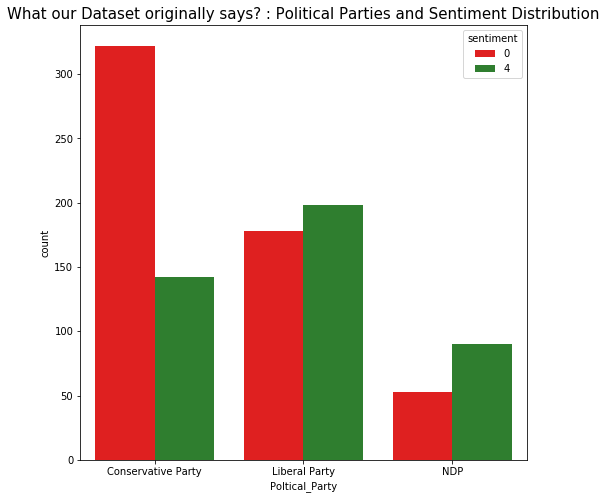

In [449]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))

sns.set_palette(sns.color_palette(['#ff0000','#228b22', '#3CAEA3', '#F5D55C']))

sns.countplot(x='Poltical_Party', hue='sentiment', data=canadian_elections_clean, 
              order = canadian_elections_clean[canadian_elections_clean['Poltical_Party'] != 'None']['Poltical_Party'].value_counts().sort_index().index, 
              ax=ax )

plt.title('What our Dataset originally says? : Political Parties and Sentiment Distribution', size=15)
plt.show()


Dataset says that Liberal party is the most positively discussed party while Conservative Party is the most negatively discussed


### 4.4.2 What does our model predict?

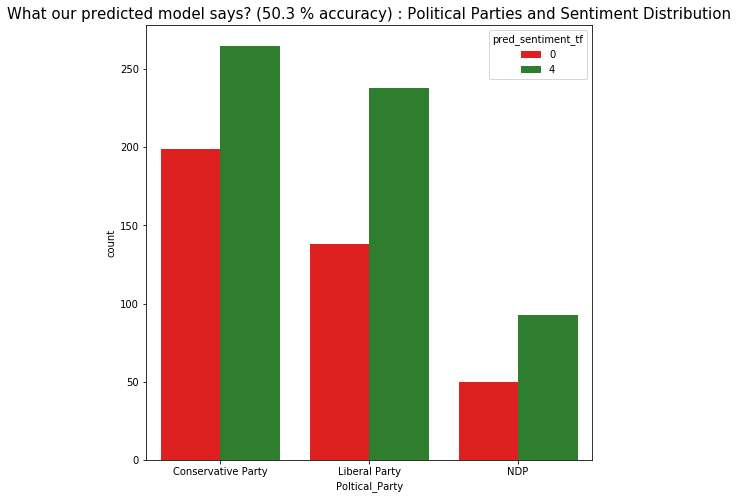

In [450]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

sns.set_palette(sns.color_palette(['#ff0000','#228b22', '#3CAEA3', '#F5D55C']))

sns.countplot(x='Poltical_Party', hue='pred_sentiment_tf', data=canadian_elections_clean, 
              order = canadian_elections_clean[canadian_elections_clean['Poltical_Party'] != 'None']['Poltical_Party'].value_counts().sort_index().index, 
              ax=ax )

plt.title('What our predicted model says? (50.3 % accuracy) : Political Parties and Sentiment Distribution', size=15)
plt.show()


Note there are differences between the original and predicted values because our model operates at 50.3 % accuracy

### 4.4.3 What does our model say?

1. Conservative party is the most discussed party with negative sentiment. This prediction matches rightly with what it originally is.

2. Though positive sentiments of Liberal is a little lesser than Conservative in our predicted results, considering 50% accuracy score and the lower negative sentiment feeling for Liberal party makes it more popular or probable to win than Conservative party. Note that negative feeling for conservative is very high as mentioned in the first point

3. Though NDP is more optimistically perceived but it is less popular than the big shot parties like Liberal and Conservative  

### 4.5 Discuss whether NLP analytics based on tweets is useful for political parties during election campaigns.

1. Performing sentiment analysis on our dataset helped us identify the perception of each of the three political parties amongst the Canadian public. 

2. Political parties can definitely make use of these to understand where they stand in public even before elections happen. This kind of analysis can give us a flavour of percentage of seats that can be won by each poltical party, who will be winning the elections and who for sure will be losing it.

3. Politicians can use this as a two-way communication with their citizens, to discover theiropinions and feelings about different ideas. 

4. NLP analytics can also be used to analyse the reasons behind positive and negative sentiments.This analysis can help each party frame their propagandas, speeches, areas of focus in a much better and consructive way.These solutions not only  help politicians to have an iterative approach in their campaigns but also adopt an ‘agile’ methodology when political communication strategy is defined. After each message, post or tweet, politicians will be able to assess the impact. 

### 4.5 Performing Logistic Regression to predict reasons for negative tweets

#### What is asked for ?
Split the negative 2019 Canadian elections tweets into training data (70%) and test data (30%). Use the sentiment labels in the 2019 Canadian elections data instead of your predictions from the previous part. Choose three algorithms from classification
algorithms (logistic regression, k-NN, Naive Bayes, SVM, decision trees, ensembles (RF,XGBoost)), train multi-class classification models to predict the reason for the negative tweets. There are 9 different negative reasons labelled in the dataset. Feel free to combine similar reasons into fewer categories as long as you justify your reasoning. You are free
to define input features of your model using word frequency analysis or other techniques.

### 4.5.1 Segregating the datapoints for negative sentiment alone

In [312]:
canadian_elections_clean.sentiment.value_counts(dropna=False)

4    1127
0    1006
Name: sentiment, dtype: int64

In [324]:
canadian_elections_clean_negative=canadian_elections_clean[canadian_elections_clean['sentiment']==0]
canadian_elections_clean_negative =canadian_elections_clean_negative.reset_index(drop=True)
canadian_elections_clean_negative.head()

,sentiment,negative_reason,text,cleaned_text,Poltical_Party,pred_sentiment,pred_sentiment_tf
0,0,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",""" @rosiebarton suggestion , agre # canadian # ...",Conservative Party,0,0
1,0,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",""" #brantford cost $ 94 billion 4 year ! justin...",Liberal Party,4,0
2,0,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...",""" #canada # taxpay sick &amp; tire hard earn $...",Liberal Party,0,4
3,0,Others,"b""#CanadaVotes2019 #elxn43 #cdnpoli - FACTS - ...",""" #canadavotes2019 # elxn43 # cdnpoli - fact -...",None,4,4
4,0,Others,"b""#chooseforward #cdnpoli #elxn43\nCanada, Don...",""" #chooseforward # cdnpoli # elxn43\ncanada , ...",Liberal Party,4,0


### 4.5.2  What are the different negative_reason categories in the dataset?

In [325]:
canadian_elections_clean_negative['negative_reason'].value_counts(dropna=False)

Others                                 364
Scandal                                270
Tell lies                              198
Economy                                 51
Women Reproductive right and Racism     45
Climate Problem                         41
Separation                              16
Privilege                               12
Healthcare                               5
Healthcare and Marijuana                 4
Name: negative_reason, dtype: int64

### 4.5.3 Note that there are 9 different negative reasons labelled in the dataset. In order to improve the performance of the model, lets club the reasons into fewer buckets :
1. Others : Keeping it as such as there's reasonably good number of data points
2. Scandal : Keeping it as such as there's reasonably good number of data points
3. Tell Lies : Keeping as such as there's reasonably good number of data points
4. Economy,Women Reproductive right and racism, climate probelm, seperation , privilege , healthcare, healthcare and marijuana: Clubbing all these categories together as there are less number of datapoints in each and the significant reason that change in any of these categories directly impact the economy

### 4.5.4 Perform Mapping

In [326]:
mapper_reason ={
'Others' : 1,                                
'Scandal':2, 
'Tell lies':3,                              
'Economy':4,                                 
'Women Reproductive right and Racism':4,     
'Climate Problem':4,                         
'Separation':4,                              
'Privilege':4,                               
'Healthcare':4,                               
'Healthcare and Marijuana':4}

In [327]:
canadian_elections_clean_negative['negative_reason']=canadian_elections_clean_negative['negative_reason'].map(mapper_reason)

In [328]:
canadian_elections_clean_negative.head(3)

,sentiment,negative_reason,text,cleaned_text,Poltical_Party,pred_sentiment,pred_sentiment_tf
0,0,4,"b""@RosieBarton So instead of your suggestion, ...",""" @rosiebarton suggestion , agre # canadian # ...",Conservative Party,0,0
1,0,4,"b""#Brantford It's going to cost YOU $94 BILLIO...",""" #brantford cost $ 94 billion 4 year ! justin...",Liberal Party,4,0
2,0,4,"b""#Canada #taxpayers are sick &amp; tired of h...",""" #canada # taxpay sick &amp; tire hard earn $...",Liberal Party,0,4


In [492]:
canadian_elections_clean_negative.negative_reason.value_counts()

1    364
2    270
3    198
4    174
Name: negative_reason, dtype: int64

### 4.5.5 Implementing TF-IDF


In [350]:
from sklearn.feature_selection import SelectPercentile, f_classif
X = canadian_elections_clean_negative['cleaned_text']
y = canadian_elections_clean_negative['negative_reason']

TV = TfidfVectorizer(analyzer='word', max_features = 6923, sublinear_tf=True, max_df=0.5, stop_words='english')

features_train, features_test, labels_train, labels_test = train_test_split(X, y, test_size=0.3, random_state=10)

features_train = TV.fit_transform(features_train)
features_test = TV.transform(features_test)

selector = SelectPercentile(f_classif, percentile=10)
selector.fit(features_train, labels_train)
features_train = selector.transform(features_train).toarray()
features_test = selector.transform(features_test).toarray()

### 4.5.6 Logitstic Regression with TF-IDF Implementation on Canadian election with negative_reason as target variable 

In [351]:
model =LogisticRegression(random_state = 0) 
model.fit(features_train, labels_train)
predictions_lr = model.predict(features_test)

score_train = model.score(features_train, labels_train)
score_test = model.score(features_test, labels_test)
 

print("\nTrain Accuracy score:{}%".format(round(score_train*100, 3)))
print("Test Accuracy score: {}%".format(round(score_test*100, 3)))


Train Accuracy score:59.943%
Test Accuracy score: 50.0%


### 4.5.7 XGBoost with TF-IDF Implementation on Canadian election with negative_reason as target variable 

In [358]:
model =GradientBoostingClassifier() 
model.fit(features_train, labels_train)
predictions = model.predict(features_test)

score_train = model.score(features_train, labels_train)
score_test = model.score(features_test, labels_test)
 

print("\nTrain Accuracy score:{}%".format(round(score_train*100, 3)))
print("Test Accuracy score: {}%".format(round(score_test*100, 3)))


Train Accuracy score:91.619%
Test Accuracy score: 58.278%


### 4.5.8 RF with TF-IDF Implementation on Canadian election with negative_reason as target variable 

In [357]:
model =RandomForestClassifier(random_state = 0) 
model.fit(features_train, labels_train)
predictions = model.predict(features_test)

score_train = model.score(features_train, labels_train)
score_test = model.score(features_test, labels_test)
 

print("\nTrain Accuracy score:{}%".format(round(score_train*100, 3)))
print("Test Accuracy score: {}%".format(round(score_test*100, 3)))


Train Accuracy score:97.869%
Test Accuracy score: 53.974%


### 4.5.9 Naive Bayes with TF-IDF Implementation on Canadian election with negative_reason as target variable 

In [355]:
model =GaussianNB() 
model.fit(features_train, labels_train)
predictions = model.predict(features_test)

score_train = model.score(features_train, labels_train)
score_test = model.score(features_test, labels_test)
     
print("\nTrain Accuracy score:{}%".format(round(score_train*100, 3)))
print("Test Accuracy score: {}%".format(round(score_test*100, 3)))


Train Accuracy score:80.682%
Test Accuracy score: 45.033%


### 4.5.10 On running different algorithms, it is clear that Logisitc regression is the best performing model even though test scores in other algorithms are higher. This is because the train and test accuracy is the closest to each other in Logisitic regression model in this case which means we are reasonably good with data-fitting 

### 5.0 Results

### 5.1 Discussion on the research statement : What can public opinion on Twitter tell us about the Canadian political landscape in 2019?

1. Regarding the tweets on Liberal Party, the distrbution of positive and negative sentiment is observed to be pretty close,as per our dataset. However, postive sentiment exceeds negative for Liberal party tweets.Therefore, it can be concluded that public opinion on Twitter for Liberal party is more positive than negative. 

2. The majority of the tweets regarding Conservative Party had negative sentiment which suggests that the overall public opinion on Twitter about the party was negative, as per our dataset.Therefore, it can be concluded that public opinion on Twitter regarding Conservative Party is majorly negative.

3. Unlike the big shot parties : Liberal and conservative, NDP or New Democrat Party has smaller percentage of tweets affiliated towards itself. And if we were analyse the distribution of sentiment for NDP, positive feelings/sentiments were more expressed than negative.Therefore, it can be concluded that public opinion on Twitter for NDP is majorly optimistic. However the point to be noted is that NDP is less popular than the other two parties. 

    Performing this kind of analysis on public tweets can give us a flavour of how each political party is perceived by he public.This kind of sentiment analysis not only speaks of political affiliations/landscape but helps predict the results of election.

##### 4.4.3 What does our model say?
1. Conservative party is the most discussed party with negative sentiment. This prediction matches rightly with what it originally is.
2. Though positive sentiments of Liberal is a little lesser than Conservative in our predicted results, considering 50% accuracy score and the lower negative sentiment feeling for Liberal party makes it more popular or probable to win than Conservative party. Note that negative feeling for conservative is very high as mentioned in the first point
3. Though NDP is more optimistically perceived but it is less popular than the big shot parties like Liberal and Conservative  

##### How can we improve accuracy?
Our built model to predict sentiment for each political party operates with an accuracy of 50.3047 %. This accuracy would have been higher if the generic_tweets dataset used to train and prepare the model had higher number of political tweets.No doubt that the dataset was huge with 200,000 rows but the number of tweets around Liberal party, Conservative and NDP were fewer in number. 


### 5.2 Discussion on model to predict reasons for negative sentiment

### 5.2.1 Let's analyse the results of prediction model by plotting confusion matrix

In [493]:
import itertools
def plot_confusion_matrix(cm, classes, title='Confusion matrix', normalize=False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fmt = '.2f' if normalize else 'd'

 

    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(cm, interpolation='nearest', cmap=cmap)

 

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=15)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

 

    thresh = (cm.max()+cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

 

    plt.tight_layout()
    plt.ylabel('True label', size=15)
    plt.xlabel('Predicted label', size=15)

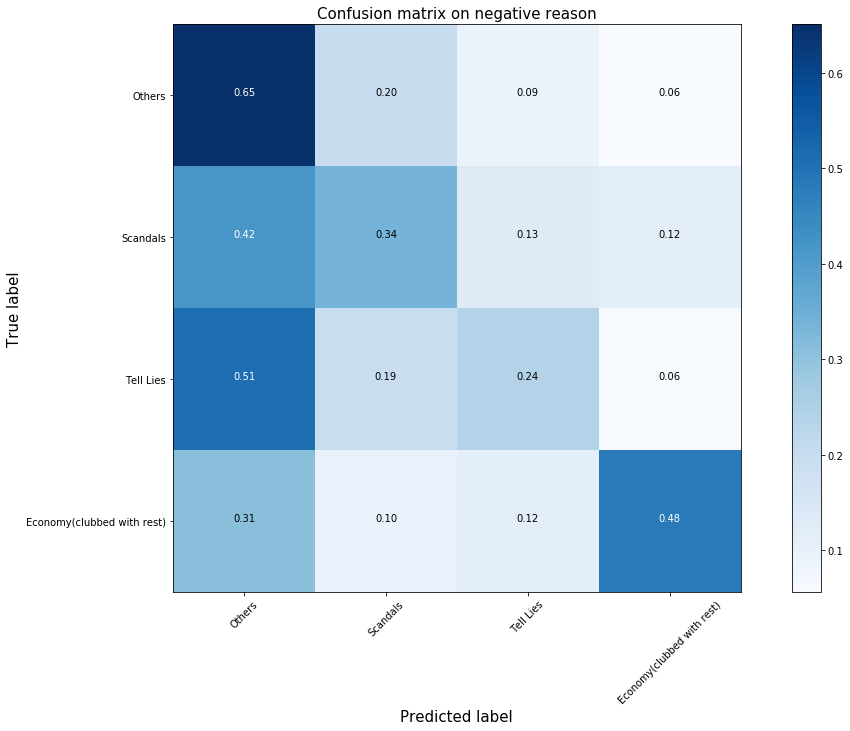

In [496]:
classes = ['Others','Scandals','Tell Lies','Economy(clubbed with rest)']
conf_mat_train = confusion_matrix(labels_test,predictions)
plot_confusion_matrix(conf_mat_train, classes, title='Confusion matrix on negative reason', normalize=True)
 

1. From the above confusion matrix, probability of right prediction for 'Others' category is the highest. The reason for it is obviously the highest number of datpoints for it.
2. Negative sentiment with economy being the reason is probable to be true for close to 50 % of the cases.
3. Prediction of 'Scandals' and 'Tell Lies' are much lower at 34% and 24% probabilities respectively 

#### How can we imporve accuracy?
##### Ensemble methods
This technique simply combines the result of multiple weak models and produce better results. This can be achieved through many ways:Bagging (Bootstrap Aggregating) and BoostingIt is always a better idea to apply ensemble methods to improve the accuracy of your model. There are two good reasons for this:
a) They are generally more complex than traditional methods.
b) The traditional methods give you a good base level from which you can improve and draw from to create your ensembles.